# Backzutaten Empfehlungen mit word-to-vec

Rezepte werden über die chefkoch.de api ausgelesen und damit ein word-to-vec nn trainiert. Im Ergebnis hoffen wir, dass jeder Zutat zu ihr passende Zutaten zugeordnet werden.

Interessante/spaßige Möglichkeit zur Weiterentwicklung: Ein NN trainieren neue Rezepte zu generieren und Rezepte zu bewerten (Bewertungen auf chefkoch können als Bewertungsfunktion genutzt werden). 

In [1]:
from six.moves import xrange
from tempfile import gettempdir
import os
import math
import copy
import codecs
import json
import requests
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

api_suche = "http://api.chefkoch.de/api/1.0/api-recipe-search.php?"
api_rezept = "http://api.chefkoch.de/api/1.0/api-recipe.php?"
rezept_url = "http://www.chefkoch.de/rezepte/"

class Data:
    
    def __init__(self,data=[]):
        
        self.Dataset = data
        self.data_index = 0
        self.min_instances = 5
        
    def update(self):
        #self.ingidlists: list of list of integers; inner lists represent recipes and contain ids of ingredients
        
        self.ingidlists = copy.deepcopy([recipe["rezept_zutaten"] for recipe in self.Dataset])
        for i in range(len(self.ingidlists)):
            templist=[]
            for ing in self.ingidlists[i]:
                templist.append(ing[0])
            self.ingidlists[i]=templist       
        
        trash = self.filter_ings()
        
        inglists = [recipe["rezept_zutaten"] for recipe in self.Dataset]
        self.id_to_name = {ingredients[i][0]:ingredients[i][1] for ingredients in inglists for i in range(len(ingredients)) \
                          if ingredients[i][0] not in trash}
        self.id_to_num = {i:j for i,j in zip(self.id_to_name.keys(),range(len(self.id_to_name)))}
        self.name_to_id = {self.id_to_name[k] : k for k in self.id_to_name}
        self.num_to_id = {self.id_to_num[k] : k for k in self.id_to_num}
        self.num_to_name = {k[0]:self.id_to_name[k[1]] for k in self.num_to_id.items()}
        self.name_to_num = {self.num_to_name[k] : k for k in self.num_to_name}
        
        self.batchfeed = [(recipe[i],recipe[j]) for recipe in self.ingidlists for i in range(len(recipe)) for j in range(len(recipe)) \
                          if i!=j and recipe[i] not in trash and recipe[j] not in trash]
        self.batchfeed = list(map(lambda x: (self.id_to_num[x[0]],self.id_to_num[x[1]]),self.batchfeed))
        
    def filter_ings(self):
        '''remove ingredients from batchfeed who show up in less than min_instances recipes
        returns set of ids which are to be removes'''
        inglists = [recipe["rezept_zutaten"] for recipe in self.Dataset]
        helpdict = {ingredients[i][0]:0 for ingredients in inglists for i in range(len(ingredients))}
        for recipe in self.ingidlists:
            for ing in recipe:
                helpdict[ing]+=1
        return set(i for i in helpdict.keys() if helpdict[i] < self.min_instances)
                                
    def generate_batch(self, batch_size):

        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
        
        maxindex = len(self.batchfeed)-1
        
        for i in range(batch_size):
            batch[i]=self.batchfeed[self.data_index][0]
            labels[i]=self.batchfeed[self.data_index][1]
            if self.data_index != maxindex:
                self.data_index += 1
            else:
                self.data_index = 0
            
        return batch, labels
    
    def get_cf_list(self, search_text, limit=2):
        params = {}
        params["Suchbegriff"] = search_text.strip()
        params["limit"] = limit # you can pass the limit amount of results you like to receive

        response = requests.get(api_suche, params=params)

        if response.status_code == 200:
            return json.loads(response.content.decode('utf-8'))
        else:
            return None

    def get_cf_details(self, id):
        params = {}
        params["ID"] = id

        response = requests.get(api_rezept, params=params)

        if response.status_code == 200:
            return json.loads(response.content.decode('utf-8'))
        else:
            return None
        
    def cleandata(self,data):
       
        keepdata = ['rezept_id','rezept_show_id','rezept_name','rezept_name2','rezept_zubereitung','rezept_portionen','rezept_preparation_time','rezept_cooking_time','rezept_resting_time','rezept_schwierigkeit','rezept_kcal','rezept_tags','rezept_user_portionen','rezept_frontend_url']
        
        resdict = data['result'][0]
        usefuldata = {i:resdict[i] for i in keepdata}
        usefuldata['rezept_zutaten'] = [(int(zutate['id']),zutate['name'],zutate['eigenschaft'],zutate['menge'],zutate['einheit']) for zutate in resdict['rezept_zutaten'] if zutate['id'] != '']
        usefuldata['rezept_votes'] = (resdict['rezept_votes']['average'],resdict['rezept_votes']['votes'])
        return usefuldata

    def get_data(self,limit=1000):
        #limit = number of recipes to fetch per category
        categories = ['Fisch','Fleisch','Burger','Pizza','asiatisch','indisch','deutsch','italienisch','polnisch','russisch','kuchen']
        included = set()

        for input in categories:
            list = self.get_cf_list(input,limit)
            for dic in list['result']:
                data = self.get_cf_details(dic['RezeptShowID'])
                usefuldata = self.cleandata(data)
                if usefuldata['rezept_id'] not in included:
                    self.Dataset.append(usefuldata)
                    included.add(usefuldata['rezept_id'])
        self.update()
        
    def write_to_file(self,filename):
        file = codecs.open(filename,'w',"utf-8")
        for item in self.Dataset:
            file.write(json.dumps(item)+'\n')
        file.close()
        
    def read_from_file(self,filename):
        file = codecs.open(filename, 'r',"utf-8")
        self.Dataset = []
        for line in file:
            self.Dataset.append(json.loads(line.strip()))
        file.close()
        self.update()
        
    def rating_frequencies(self,minvotes=0):
        votes = [recipe["rezept_votes"][0] for recipe in self.Dataset if int(recipe["rezept_votes"][1])>=minvotes]
        freqs = {rating:votes.count(rating) for rating in votes}
        return freqs
    
    def ingredients_frequencies(self):
        inglists = [recipe["rezept_zutaten"] for recipe in self.Dataset]
        ingredients = [ingredients[i][1] for ingredients in inglists for i in range(len(ingredients))]
        freqs = {ingredient:ingredients.count(ingredient) for ingredient in ingredients}
        return freqs
    
    def find_recipe_for_ing(self,ingid):
        recipelist = []
        for recipe in self.Dataset:
            for ingredient in recipe['rezept_zutaten']:
                if ingid == ingredient[0]:
                    recipelist.append((recipe['rezept_name'],recipe['rezept_show_id']))
        return recipelist
    
class NN:
    #word-2-vec
    def __init__(self,data):
        self.Data = data
        self.batch_size = 128
        self.embedding_size = 128  # Dimension of the embedding vector.
        self.skip_window = 1       # How many words to consider left and right.
        self.num_skips = 2         # How many times to reuse an input to generate a label.
        self.num_sampled = 64      # Number of negative examples to sample.
        self.update_vocabsize()
        
    def update_vocabsize(self):
        self.vocabulary_size = max(self.Data.num_to_id.keys())+1
        
    def nearest_neighbours(self,id,amount=20):
        nearest = (-self.final_embeddings[self.Data.id_to_num[id], :]).argsort()[1:amount + 1]
        return [self.Data.num_to_name[j] for j in nearest]
        
    def runNN(self):
        
        valid_size = 16     # Random set of words to evaluate similarity on.
        valid_window = 100  # Only pick dev samples in the head of the distribution.
        valid_examples = np.random.choice(valid_window, valid_size, replace=False)
        
        self.graph = tf.Graph()

        with self.graph.as_default():
            
            train_inputs = tf.placeholder(tf.int32, shape=[self.batch_size])
            train_labels = tf.placeholder(tf.int32, shape=[self.batch_size, 1])
            valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

            # Ops and variables pinned to the CPU because of missing GPU implementation
            with tf.device('/cpu:0'):
                # Look up embeddings for inputs.
                self.embeddings = tf.Variable(tf.random_uniform([self.vocabulary_size, self.embedding_size], -1.0, 1.0))
                embed = tf.nn.embedding_lookup(self.embeddings, train_inputs)

                # Construct the variables for the NCE loss
                nce_weights = tf.Variable(tf.truncated_normal([self.vocabulary_size, self.embedding_size],
                                        stddev=1.0 / math.sqrt(self.embedding_size)))
                nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))

            # Compute the average NCE loss for the batch.
            # tf.nce_loss automatically draws a new sample of the negative labels each
            # time we evaluate the loss.
            # Explanation of the meaning of NCE loss:
            #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
            loss = tf.reduce_mean(
                tf.nn.nce_loss(weights=nce_weights,
                               biases=nce_biases,
                               labels=train_labels,
                               inputs=embed,
                               num_sampled=self.num_sampled,
                               num_classes=self.vocabulary_size))

            # Construct the SGD optimizer using a learning rate of 1.0.
            optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
            
            # Compute the cosine similarity between minibatch examples and all embeddings.
            norm = tf.sqrt(tf.reduce_sum(tf.square(self.embeddings), 1, keep_dims=True))
            normalized_embeddings = self.embeddings / norm
            valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
            similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
            
            # Add variable initializer.
            init = tf.global_variables_initializer()

        # Step 5: Begin training.
        num_steps = 100001

        with tf.Session(graph=self.graph) as session:
            # We must initialize all variables before we use them.
            init.run()
            print('Initialized')

            average_loss = 0
            for step in xrange(num_steps):
                batch_inputs, batch_labels = self.Data.generate_batch(self.batch_size)
                feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

                # We perform one update step by evaluating the optimizer op (including it
                # in the list of returned values for session.run()
                _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
                average_loss += loss_val

                if step % 2000 == 0:
                    if step > 0:
                        average_loss /= 2000
                    # The average loss is an estimate of the loss over the last 2000 batches.
                    print('Average loss at step ', step, ': ', average_loss)
                    average_loss = 0

                # Note that this is expensive (~20% slowdown if computed every 500 steps)
                if step % 10000 == 0:
                    sim = similarity.eval()
                    for i in xrange(valid_size):
                        valid_word = self.Data.num_to_name[valid_examples[i]]
                        top_k = 8  # number of nearest neighbors
                        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                        log_str = 'Nearest to %s:' % valid_word
                        for k in xrange(top_k):
                            close_word = self.Data.num_to_name[nearest[k]]
                            log_str = '%s %s,' % (log_str, close_word)
                        print(log_str)
            self.final_embeddings = normalized_embeddings.eval()

    # Step 6: Visualize the embeddings.


    # pylint: disable=missing-docstring
    # Function to draw visualization of distance between embeddings.
    def plot_with_labels(self, filename=os.path.join(gettempdir(), 'tsne.png')):
        tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
        plot_only = 500
        low_dim_embs = tsne.fit_transform(self.final_embeddings[:plot_only, :])
        labels = [self.Data.num_to_name[i] for i in xrange(plot_only)]
        plt.figure(figsize=(18, 18))  # in inches
        for i, label in enumerate(labels):
            x, y = low_dim_embs[i, :]
            plt.scatter(x, y)
            plt.annotate(label,
                         xy=(x, y),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')

        plt.savefig(filename)

Daten einlesen:

In [10]:
CFData=Data()

#CFData.write_to_file('recipes2.txt') 
#Chefkoch hat die Api geändert, die Klasse müsste entsprechend umgeschrieben.

CFData.read_from_file('recipes.txt')

Word-to-vec NN trainieren. Wir geben alle 10000 Schritte für eine Auswahl an Zutaten die nächsten Nachbarn aus.

In [3]:
NNi=NN(CFData)
NNi.runNN()

Initialized
Average loss at step  0 :  130.30029296875
Nearest to Ingwerpulver: Schalotte(n), Dinkelmehl, Orangenschale, Avocado(s), Rum, Weizenmehl Type 405, Olivenöl, Barbecuesauce,
Nearest to Petersilienwurzel(n): Hähnchenbrüste, Fleischwurst, Sahnesteif, Mandelmehl, Hühnerbrühe, Zitrone(n), Knoblauchgranulat, Roulade(n),
Nearest to Birne(n): Parmesan, Worcestersauce, Ziegenkäse, Burgerbrötchen, Pimentkörner, Roggenmehl, Schweinefilet(s), Ingwerpulver,
Nearest to Bailey's Irish Cream: Grieß, Speisestärke, Paprikapulver, edelsüß, Hackfleisch, Curry, Shrimps, Koriander, Anis,
Nearest to Chilischote(n): Letscho, Brötchen, Öl, Jackfrucht, Mie-Nudeln, Aceto balsamico, Milch, Ananassaft,
Nearest to Limone(n): Möhre(n), Brühe, Aprikose(n), Kümmelpulver, Jackfrucht, Hefe, Kichererbsen, Bauchspeck,
Nearest to Möhre(n): Limone(n), Gehacktes, Lebkuchengewürz, Brühe, Maisgrieß, Fleischbrühe, Avocado(s), Mangold,
Nearest to Tomatensaft: Kakaopulver, Zwiebel(n), rot, Vanilleschote(n), Schweinefil

Average loss at step  32000 :  3.98517074239254
Average loss at step  34000 :  3.837145548701286
Average loss at step  36000 :  3.8366934822797774
Average loss at step  38000 :  3.987980308294296
Average loss at step  40000 :  3.881585874915123
Nearest to Ingwerpulver: Zitronenschale, Obst, Pfefferkörner, Cashewnüsse, Rum, Weizenmehl Type 405, Ingwer, Spitzkohl,
Nearest to Petersilienwurzel(n): Hähnchenbrüste, Hühnerbrühe, Sahnesteif, Zitrone(n), Fleischwurst, Scampi, Kürbis(se), Huhn,
Nearest to Birne(n): Hähnchenbrustfilet(s), Liebstöckel, Spargel, Ziegenkäse, Schweinefilet(s), Roggenmehl, Orange(n), Hähnchen,
Nearest to Bailey's Irish Cream: Grieß, Koriander, Quark, Shrimps, Kirsche(n), Lebensmittelfarbe, Hähnchenbrustfilet(s), Tortenguss,
Nearest to Chilischote(n): Koriander, Sesamöl, Ingwer, Kokosmilch, Sojasauce, Sake, Koriandergrün, Kurkuma,
Nearest to Limone(n): Kalbfleisch, Kichererbsen, Aprikose(n), Kasseler, Kardamom, Jackfrucht, Chips, Konfitüre,
Nearest to Möhre(n): Karott

Average loss at step  72000 :  3.792421855151653
Average loss at step  74000 :  3.9386749827861784
Average loss at step  76000 :  3.8327191761732102
Average loss at step  78000 :  3.9025135040283203
Average loss at step  80000 :  3.798171113014221
Nearest to Ingwerpulver: Ingwer, Zitronenschale, Spitzkohl, Worcestershiresauce, Sherry, Fenchel, Obst, Paprikaschote(n),
Nearest to Petersilienwurzel(n): Huhn, Wacholderbeere(n), Schweinebauch, Rinderfond, Leber, Sellerie, Lorbeerblätter, süße Sahne,
Nearest to Birne(n): Hähnchenbrustfilet(s), Liebstöckel, Pfefferkörner, Paprikaschote(n), rot, Fisch, Camembert(s), Schweinefilet(s), Ziegenkäse,
Nearest to Bailey's Irish Cream: Grieß, Kirsche(n), Nutella, Hackfleisch, Mascarpone, Rum, Sternanis, Shrimps,
Nearest to Chilischote(n): Öl, Sojasauce, Zwiebel(n), Paprikaschote(n), Salz, Chilisauce, Koriandergrün, Sauce,
Nearest to Limone(n): Kalbfleisch, Wein, Kichererbsen, Kardamom, Knoblauchzehe(n), Rosmarin, Chips, Konfitüre,
Nearest to Möhre(n):

Baileys mit Grieß, Nutella und co?

In [6]:
CFData.find_recipe_for_ing(CFData.name_to_id["Bailey's Irish Cream"])

[('Baileys - Schoko - Krokant - Kuchen', '1037411208856771'),
 ('Schoko - Baileys - Mandel Kuchen', '262951102417680'),
 ('Kaffee - Kuchen', '1851181299945771'),
 ('Kaffee - Kuchen', '1851181299945771'),
 ('Blitz - Apfel - Mandel - Kuchen mit Punschguss', '948541200389300')]

Aha, Kuchen!

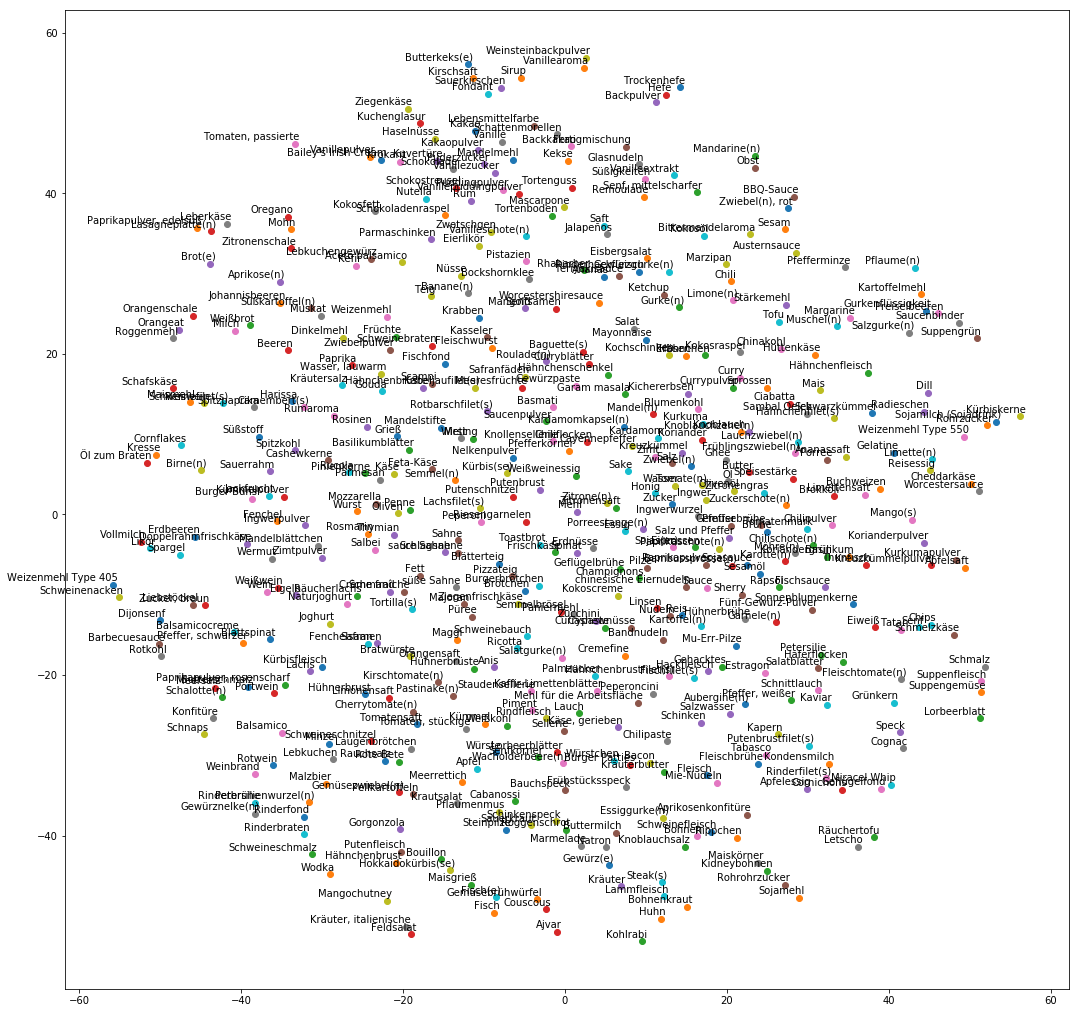

In [173]:
NNi.plot_with_labels()

Was passt zu Dill?

In [182]:
id = CFData.name_to_id['Dill']
nearest = (-NNi.final_embeddings[NNi.Data.id_to_num[id], :]).argsort()[0:10]
[NNi.Data.num_to_name[j] for j in nearest]

['Petersilienwurzel(n)',
 'Birne(n)',
 'Zwiebel(n)',
 'Knollensellerie',
 'Estragon',
 'Joghurt',
 'Reisessig',
 'Schafskäse',
 'Schmand',
 'Rohrzucker']